# Specific Test III. Learning Mass of Dark Matter Halo 

**Task: Using the provided dataset implement a regression algorithm to learn the mapping between lensing images and the lensing dark matter halo mass. You can use the machine learning algorithm of your choice.  Please implement your approach in PyTorch or Keras and discuss your strategy.**

 **LET'S IMPORT SOME OF THE LIBRARIES**

In [1]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
from tqdm import tqdm
from sklearn.utils import shuffle
from tensorflow.keras import layers
from tensorflow import keras
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.11.0


> **modify() Function to reshape image from (150,150,1) to (150,150,3)**

In [2]:
def modify(image):
    image = image.reshape((150,150,1))
    img = tf.reshape(tf.broadcast_to(image, (150, 150, 3)),  (150, 150, 3))
    return img

In [3]:
path = '/kaggle/input/lense-data/lens_data/'

> # CUSTOM DATA GENERATOR
**Since Dataset was Large enough to handle , We need efficient way to take care of it.**
Notations
Before getting started, let's go through a few organizational tips that are particularly useful when dealing with large datasets.
Let ID be the Python string that identifies a given sample of the dataset. A good way to keep track of samples and their labels is to adopt the following framework:
> > 1.) Create a dictionary called partition where you gather:
> > > in partition['train'] a list of training IDs

> > > in partition['validation'] a list of validation IDs

> > 2.) Create a dictionary called labels where for each ID of the dataset, the associated label is given by labels[ID]

> First, let's write the initialization function of the class. We make the latter inherit the properties of keras.utils.Sequence so that we can leverage nice functionalities such as multiprocessing.

> We put as arguments relevant information about the data, such as dimension sizes (e.g. a volume of length 32 will have dim=(32,32,32)), number of channels, number of classes, batch size, or decide whether we want to shuffle our data at generation. We also store important information such as labels and the list of IDs that we wish to generate at each pass.

> Here, the method on_epoch_end is triggered once at the very beginning as well as at the end of each epoch. If the shuffle parameter is set to True, we will get a new order of exploration at each pass (or just keep a linear exploration scheme otherwise).

> Shuffling the order in which examples are fed to the classifier is helpful so that batches between epochs do not look alike. Doing so will eventually make our model more robust.

> Another method that is core to the generation process is the one that achieves the most crucial job: producing batches of data. The private method in charge of this task is called __data_generation and takes as argument the list of IDs of the target batch.

> During data generation, this code reads the NumPy array of each example from its corresponding file ID.npy. Since our code is multicore-friendly, note that you can do more complex operations instead (e.g. computations from source files) without worrying that data generation becomes a bottleneck in the training process.

> Also, please note that we used Keras' keras.utils.to_categorical function to convert our numerical labels stored in y to a binary form (e.g. in a 6-class problem, the third label corresponds to [0 0 1 0 0 0]) suited for classification.

> Now comes the part where we build up all these components together. Each call requests a batch index between 0 and the total number of batches, where the latter is specified in the __len__ method.

> A common practice is to set this value to
                ⌊#samples/batch size⌋
so that the model sees the training samples at most once per epoch.
Now, when the batch corresponding to a given index is called, the generator executes the __getitem__ method to generate it.


In [4]:
def modifyVIT(image):
    image = image.reshape((150,150,1))
    img = tf.reshape(tf.broadcast_to(image, (150, 150, 3)),  (150, 150, 3))
    img = tf.image.resize(np.array(img),[224,224])
    return img

In [5]:
import numpy as np
import keras
import os
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs,Architecture, batch_size=32, dim=(150,150), n_channels=1,n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.Architecture = Architecture
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            


    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img = np.load(path+ID,allow_pickle = True)
            if self.Architecture == 'Resnet50':
                image = modify(img[0])
            else:
                image = modifyVIT(img[0])
            X[i,] = image
            y[i] = img[1]

        return np.array(X), np.array(y)

In [6]:
import random
trains = []
l=0
trains = [str(i) for i in os.listdir(path)]
random.shuffle(trains)
train_data = trains[:18000]
val_data = trains[18000:20000]

In [7]:
partition = {'train': train_data , 'validation' : val_data}

In [8]:
params = {'dim': (150,150),
          'batch_size': 64,
          'n_classes': 3,
          'n_channels': 3,
          'shuffle': True}

# MODEL

In [9]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
# local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = ResNet50(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = 'imagenet')

# Load the pre-trained weights you downloaded.
# pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
    layer.trainable = False
    
last_layer = pre_trained_model.get_layer('pool1_pad')
print('last layer output shape: ', last_layer.output_shape)
last_output = pre_trained_model.output

94765736/94765736 [==============================] - 1s 0us/step
last layer output shape:  (None, 77, 77, 64)


In [10]:
pre_trained_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']      

In [11]:


from tensorflow.keras.optimizers import SGD
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(32, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1,activation=None)(x)           

# Append the dense network to the base modeltmax
model = Model(pre_trained_model.input, x) 

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']         

In [12]:
# Generators
training_generator = DataGenerator(partition['train'] ,Architecture = 'Resnet50', **params)
validation_generator = DataGenerator(partition['validation'],Architecture = 'Resnet50', **params)

In [13]:
model.compile(optimizer = SGD(learning_rate=0.0001), 
              loss = tf.keras.losses.MeanSquaredError(), 
              metrics = [tf.keras.metrics.RootMeanSquaredError()])

In [14]:
history = model.fit(training_generator,epochs = 20, batch_size = 64,validation_data = validation_generator)

Epoch 1/20
281/281 [==============================] - 270s 909ms/step - loss: 30.9627 - root_mean_squared_error: 5.5644 - val_loss: 9.4803e-06 - val_root_mean_squared_error: 0.0031
Epoch 2/20
281/281 [==============================] - 92s 329ms/step - loss: 1.1380e-05 - root_mean_squared_error: 0.0034 - val_loss: 3.6920e-06 - val_root_mean_squared_error: 0.0019
Epoch 3/20
281/281 [==============================] - 92s 327ms/step - loss: 6.5821e-06 - root_mean_squared_error: 0.0026 - val_loss: 2.5009e-06 - val_root_mean_squared_error: 0.0016
Epoch 4/20
281/281 [==============================] - 94s 333ms/step - loss: 2.6404e-06 - root_mean_squared_error: 0.0016 - val_loss: 2.1891e-06 - val_root_mean_squared_error: 0.0015
Epoch 5/20
281/281 [==============================] - 93s 330ms/step - loss: 4.5944e-06 - root_mean_squared_error: 0.0021 - val_loss: 1.9069e-06 - val_root_mean_squared_error: 0.0014
Epoch 6/20
281/281 [==============================] - 92s 329ms/step - loss: 3.8311e-06

In [15]:
# model.save_weights('/kaggle/working/Weights-3')

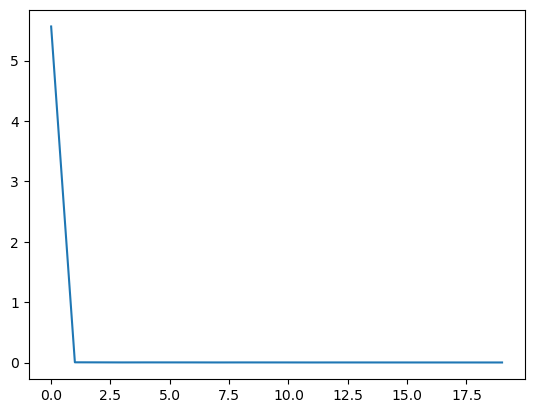

In [16]:
plt.plot(history.history['root_mean_squared_error'])

In [17]:
print('hello')

hello


In [18]:
!pip install --quiet vit-keras

from vit_keras import vit

In [19]:
vit_model = vit.vit_b32(
        image_size = (224,224),
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 2)

353253686/353253686 [==============================] - 2s 0us/step


/opt/conda/lib/python3.7/site-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  UserWarning,


In [20]:
import tensorflow_addons as tfa

In [21]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1)
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87455232  
                                                                 
 flatten_1 (Flatten)         (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 11)                8459      
                                                                 
 batch_normalization_1 (Batc  (None, 11)               44        
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 1)          

In [22]:
# Generators
params = {'dim': (224,224),
          'batch_size': 64,
          'n_classes': 3,
          'n_channels': 3,
          'shuffle': True}
training_generator = DataGenerator(partition['train'] ,Architecture = 'VIT', **params)
validation_generator = DataGenerator(partition['validation'],Architecture = 'VIT', **params)

In [23]:
learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.MeanSquaredError(), 
              metrics = [tf.keras.metrics.RootMeanSquaredError()])


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

callbacks = [reduce_lr]

HISTORY = model.fit(training_generator,validation_data = (validation_generator),epochs = 20,callbacks = callbacks, verbose = 1)

Epoch 1/20
281/281 [==============================] - 344s 1s/step - loss: 0.7333 - root_mean_squared_error: 0.8563 - val_loss: 0.1866 - val_root_mean_squared_error: 0.4320 - lr: 1.0000e-04
Epoch 2/20
281/281 [==============================] - 310s 1s/step - loss: 0.0785 - root_mean_squared_error: 0.2801 - val_loss: 0.0482 - val_root_mean_squared_error: 0.2194 - lr: 1.0000e-04
Epoch 3/20
281/281 [==============================] - 308s 1s/step - loss: 0.0380 - root_mean_squared_error: 0.1949 - val_loss: 0.0167 - val_root_mean_squared_error: 0.1292 - lr: 1.0000e-04
Epoch 4/20
281/281 [==============================] - 313s 1s/step - loss: 0.0238 - root_mean_squared_error: 0.1541 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0839 - lr: 1.0000e-04
Epoch 5/20
281/281 [==============================] - 308s 1s/step - loss: 0.0165 - root_mean_squared_error: 0.1285 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0706 - lr: 1.0000e-04
Epoch 6/20
281/281 [==============================

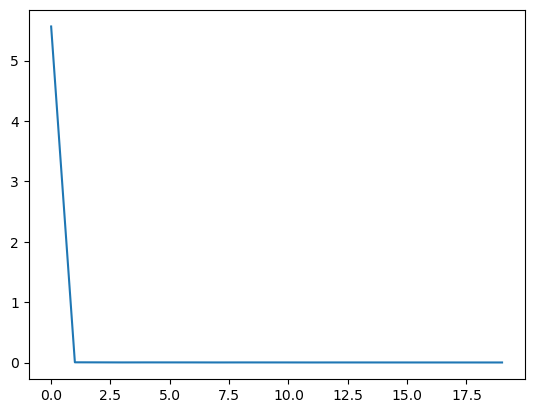

In [24]:
plt.plot(history.history['root_mean_squared_error'])

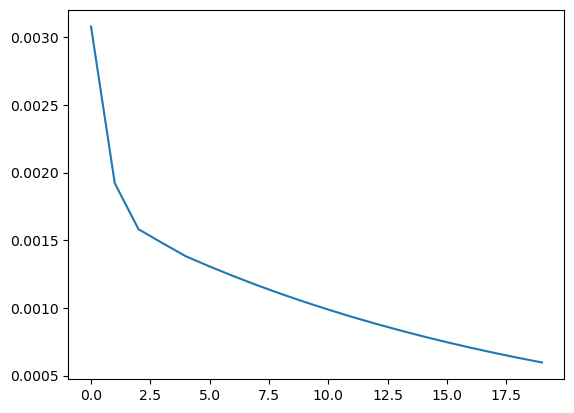

In [25]:
plt.plot(history.history['val_root_mean_squared_error'])

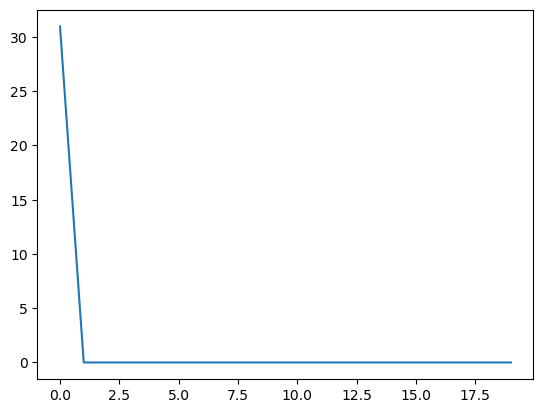

In [26]:
plt.plot(history.history['loss'])

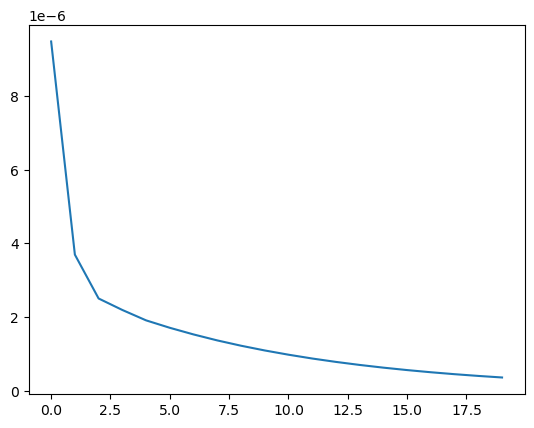

In [27]:
plt.plot(history.history['val_loss'])